In [474]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [34]:
PROJECT_PATH = '../'
DATA_PATH = '/scratch/ceph/swei20/data/ae/dataset/test'
PCA_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/pca/spectra.h5'
sys.path.insert(0, PROJECT_PATH)

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [7]:
import tensorflow as tf
# tf.enable_v2_behavior()
gpus = tf.config.list_physical_devices('GPU') 
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Loading Data

In [35]:
with h5py.File(PCA_PATH, 'r') as f:
    flux = f['flux'][()]

In [39]:
def prepro_pca(flux, dim=300):
    flux0 = flux.reshape(-1, 1000)[:, :dim]    
    flux_clean = flux0[~np.isnan(flux0[:,0])]    
    print(flux_clean.shape, flux0.shape)
    print('min', flux_clean.min(), 'max', flux_clean.max(),'mean', flux_clean.mean(),'std', flux_clean.std() )
    return flux_clean

In [40]:
flux1 = prepro_pca(flux, dim=300)

(116614, 300) (243936, 300)
min -184.9254058126797 max 145.24091665337806 mean -0.10353327716635463 std 2.4000601615265493


In [766]:
flux30 = flux1[:, :32]

In [767]:
flux30.shape

(116614, 32)

# Scaled RMS
AFTER 50 EPOCHS
input_dim=300, latent_dim=32, hidden_dims=[256, 128], dropout=0.0, lr=0.003, reg1=1e-06, loss='mae', opt='adam', batchnorm=0
epoch=50, batch_size=16, validation_split=0.3, verbose=0
mae_lr2_l32_h256_h128_INleEMleHDle_t_act_0702_120042

### 0.0 NO SCALING (BEST):
     ACC 95.9% | VACC 89.04%

### 0.1:
    ACC 95.73% | VACC 83.54%
    
### 0.3:
    ACC 94.49% | VACC 77.52%
  
### 2/3 (0.66):
    ACC 90.14% | VACC 63.06%
Epoch 5/5
5102/5102 [==============================] - 12s 2ms/step - loss: 0.0949 - acc: 0.8623 - val_loss: 0.3018 - val_acc: 0.6527

### 0.8:
Epoch 5/5
5102/5102 [==============================] - 12s 2ms/step - loss: 0.1369 - acc: 0.7936 - val_loss: 0.4246 - val_acc: 0.4212



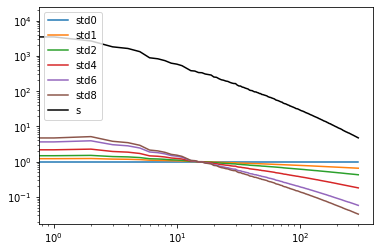

In [663]:
for rate in [0.0, 0.1, 0.2, 0.4, 2/3, 0.8]:
    name = str(rate)[-1]
    plt.plot(std300**rate, label=f'std{name}')

plt.plot(s[:300]**0.5,label='s', color='k')
plt.yscale('log')
plt.xscale('log')
plt.legend()

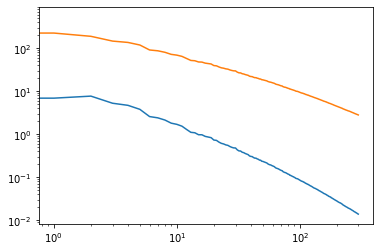

In [616]:
plt.plot(std300)
plt.plot(s[:300]**0.333)
plt.yscale('log')
plt.xscale('log')

In [608]:
flux_std.shape

(116614, 300)

In [771]:
DATA_PATH = "/home/swei20/AE/data"
SAVE_PATH = os.path.join(DATA_PATH, 'pc32.h5')

In [772]:
with h5py.File(SAVE_PATH, 'w') as f:
    f.create_dataset('flux', data = flux30)
#     f.create_dataset('flux10kmm', data = flux10kmm)

In [415]:
with h5py.File(SAVE_PATH, 'a') as f:
    f.create_dataset('flux_std50k', data = flux_std10)
#     f.create_dataset('flux10kmm', data = flux10kmm)

In [638]:
with h5py.File(SAVE_PATH, 'a') as f:
    f.create_dataset('flux_std23', data = flux_std23)
#     f.create_dataset('flux10kmm', data = flux10kmm)

In [479]:
with h5py.File(SAVE_PATH, 'r') as f:
    x_train = f['flux'][()]
#     flux10kmm = f['flux10kmm'][()]

In [508]:
with h5py.File(PCA_PATH, 'r') as f:
#     fx_eigv = f['flux_eigv'][()]
    wave = f['wave'][()]    

In [630]:
with h5py.File(PCA_PATH, 'r') as f:
#     fx_eigv = f['flux_eigv'][()]
    s = f['flux_eigs'][()]    

In [631]:
with h5py.File(PCA_PATH, 'r') as f:
#     fx_eigv = f['flux_eigv'][()]
    v = f['flux_eigv'][()]    

In [633]:
eg0.shape

(1000,)

In [632]:
v.shape

(15404, 1000)

## AE

In [665]:
from ae.pipeline.simple_ae_pipeline import SimpleAEPipeline

In [666]:
sp=SimpleAEPipeline()

In [669]:
config_dict ={
    "data": {
      "dir":"./data",
      "filename": "pca.h5",
      "train": "flux",
      "std_rate": 0.0
    },
    "model":{
      "aug": 1,
      "name": "t_act_",
      "input_dim": 300,
      "latent_dim": 32,
      "hidden_dims": [256, 128],
      "dropout": 0.0,
      "lr": 0.003,
      "reg1": 0.000001,
      "loss": "mae",
      "opt": "adam",
      "batchnorm": 0,
      "act_in": "leaky",
      "act_em": "leaky",
      "act_hd": "leaky"
    },
    "trainer":{
      "epoch": 20,
      "batch_size": 16,
      "validation_split":0.3,
      "verbose": 1
    },
    "callbacks":{
        "checkpoint_monitor": "val_loss",
        "checkpoint_mode": "min"
    }
}
config = DotMap(config_dict)

In [670]:
from ae.model.simple_ae_model import SimpleAEModel
from ae.trainer.simple_ae_trainer import SimpleAETrainer

In [671]:
mm = SimpleAEModel()
mm.build_model(config)

INFO:root:Layers: [300, 256, 128, 32]
INFO:root:NAME: mae_lr2_l32_h256_h128_INleEMleHDle_t_act_0702_123331


In [672]:
data = x_train
tt = SimpleAETrainer(mm, config)
history = tt.train((data, data), ep=20)

Epoch 1/20
5102/5102 [==============================] - 17s 3ms/step - loss: 0.0630 - acc: 0.8490 - val_loss: 0.1294 - val_acc: 0.8484
Epoch 2/20
5102/5102 [==============================] - 16s 3ms/step - loss: 0.0433 - acc: 0.9183 - val_loss: 0.1105 - val_acc: 0.8462
Epoch 3/20
5102/5102 [==============================] - 16s 3ms/step - loss: 0.0394 - acc: 0.9282 - val_loss: 0.1098 - val_acc: 0.8458
Epoch 4/20
5102/5102 [==============================] - 16s 3ms/step - loss: 0.0371 - acc: 0.9308 - val_loss: 0.1084 - val_acc: 0.8752
Epoch 5/20
5102/5102 [==============================] - 16s 3ms/step - loss: 0.0356 - acc: 0.9356 - val_loss: 0.1079 - val_acc: 0.8474
Epoch 6/20
5102/5102 [==============================] - 15s 3ms/step - loss: 0.0347 - acc: 0.9384 - val_loss: 0.1025 - val_acc: 0.8494
Epoch 7/20
5102/5102 [==============================] - 15s 3ms/step - loss: 0.0338 - acc: 0.9388 - val_loss: 0.1032 - val_acc: 0.8675
Epoch 8/20
5102/5102 [==============================] -

In [673]:
mm.name

'mae_lr2_l32_h256_h128_INleEMleHDle_t_act_0702_123331'

In [680]:
mm.save()

Saving model...
Model saved


In [574]:
mm1 = SimpleAEModel()
mm1.build_model(config)

INFO:root:Layers: [300, 256, 128, 32]
INFO:root:NAME: mae_lr2_l32_h256_h128_INleEMleHDle_t_act_0702_095524


In [575]:
mm1.load("/home/swei20/AE/trained_model/")

Loading model checkpoint /home/swei20/AE/trained_model ...

Model loaded


In [580]:
aa = mm1.model.predict(x_train[:1])

In [583]:
aa.shape

(1, 300)

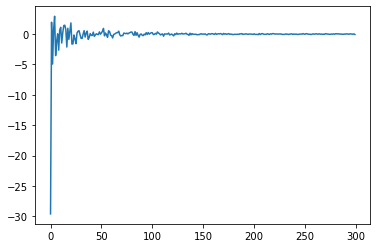

In [586]:
plt.plot(aa[0])

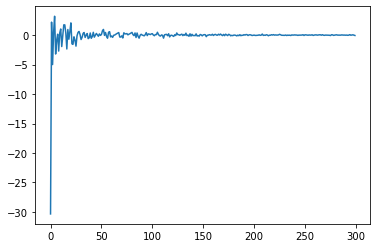

In [587]:
plt.plot(x_train[0])

In [488]:
def get_last_epoch_accs(model):
    val_acc = model.history.history['val_acc'][-1]
    acc = model.history.history['acc'][-1]
    acc, val_acc = np.around(acc*100, 2), np.around(val_acc*100, 2)
    print(f"ACC {acc}% | VACC {val_acc}%")


In [682]:
# mm.model.history.history

In [688]:
np.sum(fx_eigv**2, axis=1)

array([0.38707911, 0.28734666, 0.26158776, ..., 0.00508941, 0.00722541,
       0.02216585])

In [689]:
eigv300 = fx_eigv[:,:300]

In [690]:
U = np.cumsum(eigv300**2, axis=1)
U.shape

(15404, 300)

In [697]:
np.mean(U[:,k])

0.0013632822643469234

In [708]:
np.mean(eigv300, axis = 0)

array([ 4.77684293e-03,  1.01122920e-04, -4.01209273e-03,  5.34551782e-04,
        1.95560837e-03,  7.09552525e-04, -2.22936424e-04,  8.24337131e-06,
       -4.56905763e-04,  1.02550040e-03, -3.23732849e-04,  1.29954216e-06,
       -2.06814585e-04, -7.92651441e-04,  4.39047845e-04, -8.87156140e-05,
       -2.93390354e-04, -1.38875790e-03, -3.36307804e-04,  5.21420808e-04,
       -3.31456483e-04,  6.73731397e-04,  2.40606674e-05,  2.86522293e-04,
        1.69552238e-04,  3.55659066e-04, -6.15745857e-04,  5.55172833e-04,
       -1.48370769e-04, -1.11414426e-04, -4.11573526e-04, -1.69368113e-04,
        5.74572627e-04, -4.56128517e-04,  4.36126895e-04, -6.19747643e-04,
        2.49323032e-04,  3.30045325e-04, -1.51459374e-04, -2.34295357e-04,
        9.52935974e-05,  7.95171386e-04, -2.52867871e-04, -5.01050298e-05,
       -9.95369690e-04, -4.75851372e-05,  5.18050682e-04,  1.26894965e-05,
        1.26973565e-05, -4.59424595e-04, -2.86961702e-06,  4.89748596e-04,
        4.13940692e-04,  

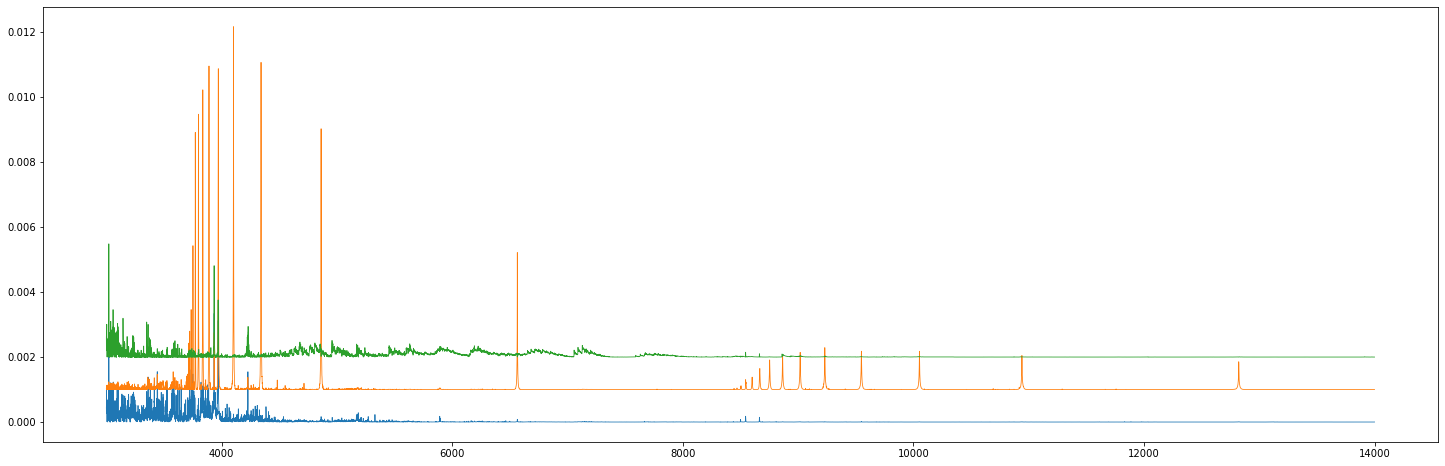

In [706]:
f, ax = plt.subplots(figsize=(25, 8))
shift = [0, 0.001, 0.002]
for i, k in enumerate([0,1,2]):
    ax.plot(wave,(eigv300**2)[:,k] + shift[i], lw=0.8)

[]

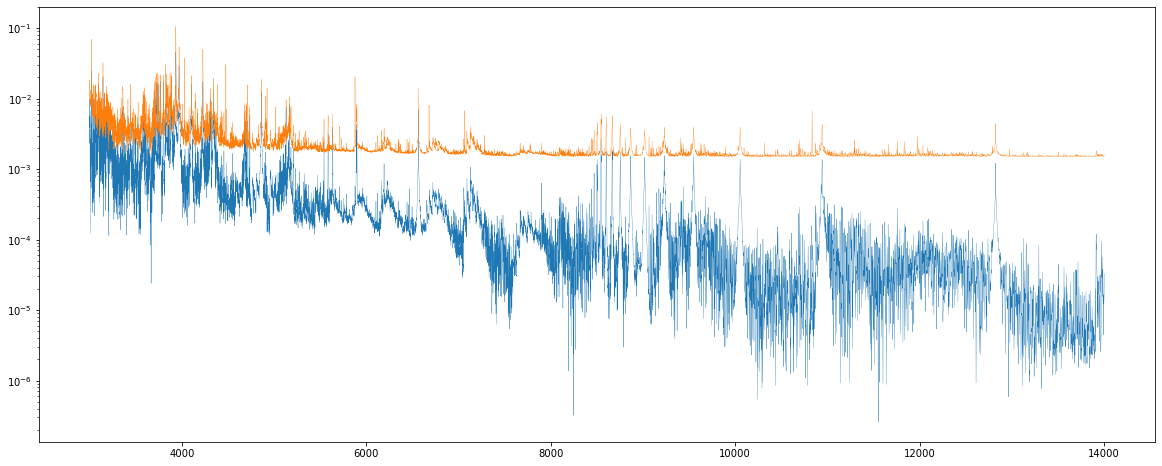

In [696]:
f, ax = plt.subplots(figsize=(20, 8))
ii = [0, 0.001]
for i, k in enumerate([10,20]):
    ax.plot(wave, U[:, k] + ii[i], lw=0.3)
ax.semilogy()

In [ ]:
f, ax = plt.subplots(figsize=(8, 5))
for k in [10,20,30,50,100]:
    ax.plot(wave, U[:, k], lw=0.3)
ax.semilogy()

In [591]:
ae_pred = mm.model.predict(x_train)

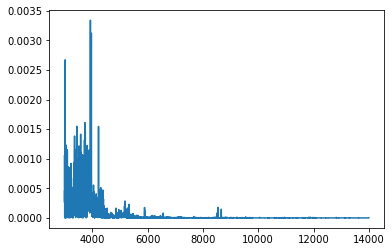

In [637]:
plt.plot(wave, eg0**2)

In [494]:
eigv300 = fx_eigv[:, :300]

In [607]:
x_train.shape

(116614, 300)

In [592]:
flux_org = x_train.dot(eigv300.T)
flux_rec = ae_pred.dot(eigv300.T)

In [594]:
err= np.abs(flux_org -flux_rec)

In [595]:
np.mean(np.sum(err, axis=1))

108.08298797191254

In [555]:
class Eval(object):
    def __init__(self, wave, org, rec, err=None):
        self.org=org
        self.rec=rec
        self.wave=wave
        self.abs_err= err
    
    def get_abs_err(self):
        return abs(self.org - self.rec)
    
    def plot_flux(self, idx, ax=None):
        ax = ax or plt.gca()
        ax.plot(self.wave, self.org[idx], c='k', label='pca')
        ax.plot(self.wave, self.rec[idx], alpha=0.5, c='r', label='rec')
        ax.set_xlim(self.wave[0], self.wave[-1])
        ax.legend(loc=4)
        
    def plot_err(self, idx, ax=None):
        ax = ax or plt.gca()
        ax.plot(self.wave, self.abs_err[idx], c='k', label='abs_err')
        ax.set_xlim(self.wave[0], self.wave[-1])
        ax.legend(loc=1)
        
    def plot_all(self, idx):
        f, axs = plt.subplots(2,1, figsize=(20,10), sharex="all")
        self.plot_flux(idx, ax=axs[1])
        self.plot_err(idx, ax=axs[0])
        

In [568]:
err= np.abs(flux_org -flux_rec)

In [601]:
e = Eval(wave, flux_org, flux_rec, err=err)

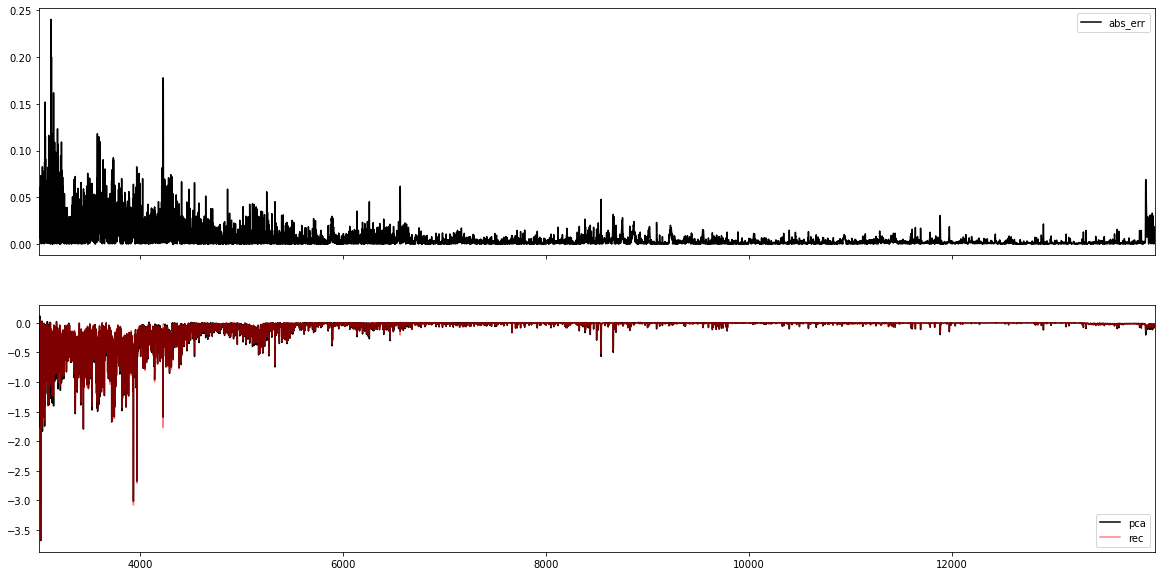

In [602]:
e.plot_all(0)

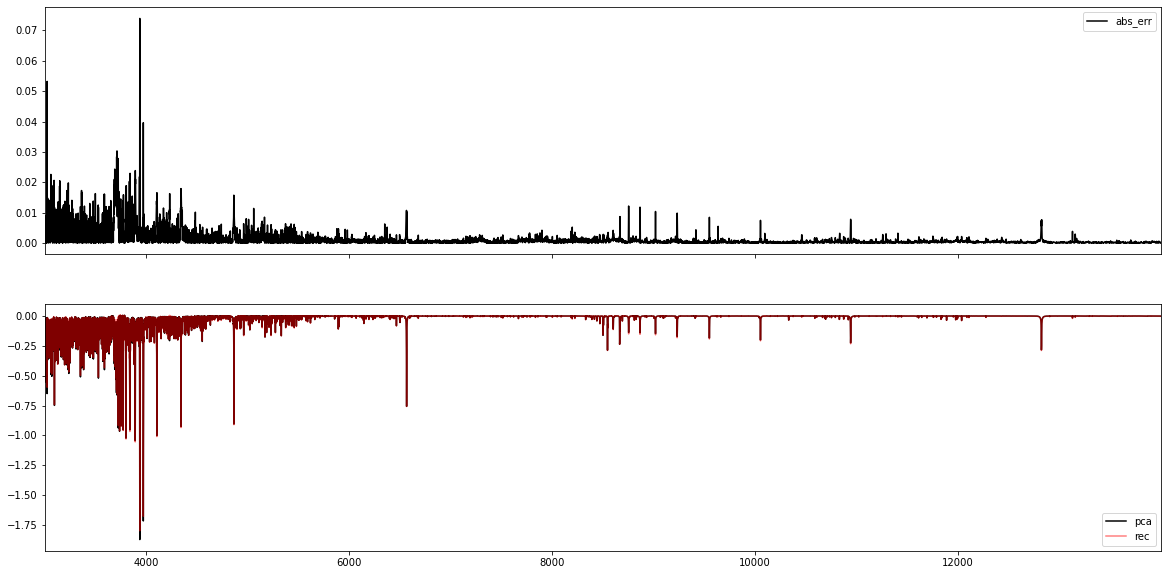

In [603]:
e.plot_all(10000)

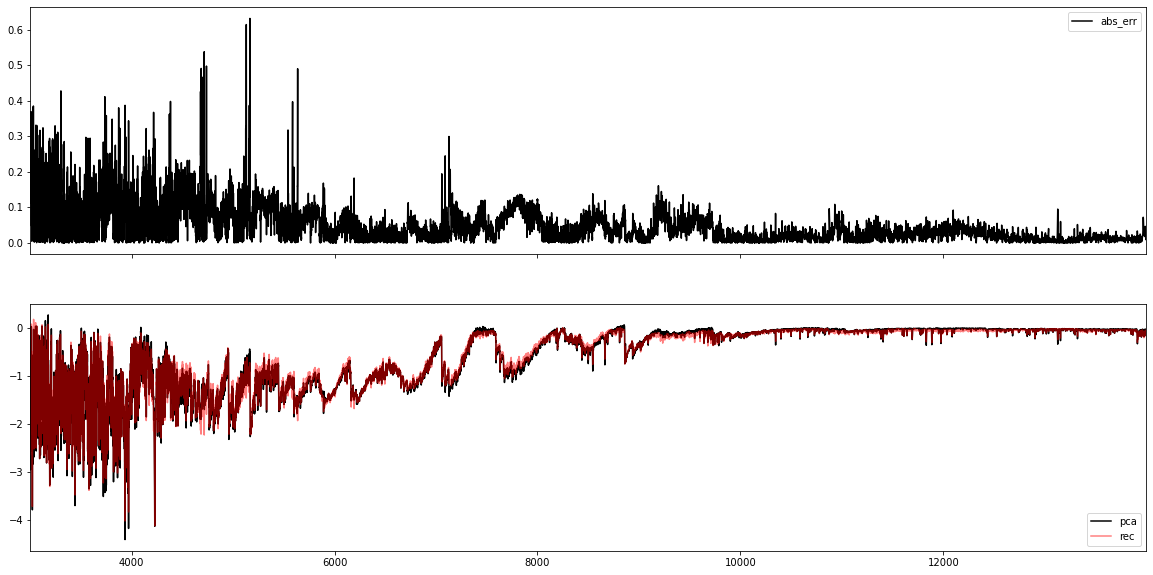

In [604]:
e.plot_all(100000)

In [ ]:
idx = 0
f, axs = plt.subplots(2,1, figsize(30,20))

axs.plot(wave, flux_org[0], 'k')
plt.plot(wave, flux_rec[0], alpha=0.5, c='r')

In [ ]:
def plot_flux(flu)

[[<matplotlib.lines.Line2D at 0x7f7a60f77bb0>],

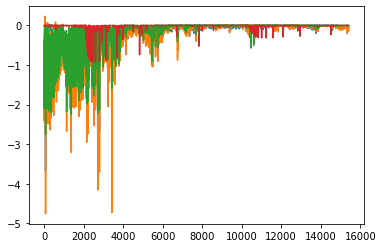

In [504]:
[plt.plot(wave, flux_org[i]) for i in [0,100,1000,40000]]

[[<matplotlib.lines.Line2D at 0x7f7a60f13550>],

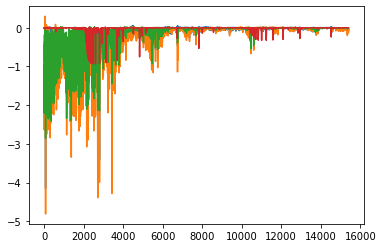

In [507]:
[plt.plot(flux_rec[i]) for i in [0,100,1000,40000]]

## 1. Verify MSE

### A. On small random matrix

In [718]:
from scipy.stats import ortho_group

In [740]:
rand_mat = np.random.random(size=(7, 4))
psi, _ = np.linalg.qr(rand_mat)
np.sum(psi**2, 0), psi.shape

(array([1., 1., 1., 1.]), (7, 4))

In [747]:
aa = np.array([[1,2,3,4]])
bb = np.array([[1.2,1.8, 2.5,4.1]])
np.sum((aa - bb)**2)
# bb = np.array([[1.2,1.8, 2.5,4.1,5.1 ,5.9, 6.8]])

0.3399999999999999

In [752]:
saa = aa.dot(psi.T)
sbb = bb.dot(psi.T)
np.sum((saa - sbb)**2), saa.shape,

(0.3399999999999995, (1, 7))

### B. On specs

In [755]:
def get_mse(org, rec):
    diff = np.sum((org - rec)**2 , 1)
    mse = np.mean(diff)
    print(org.shape, rec.shape, diff.shape, mse)

In [756]:
get_mse(x_train, ae_pred)

(116614, 300) (116614, 300) (116614,) 18.589451421547338


In [757]:
flux_org = x_train.dot(eigv300.T)
flux_rec = ae_pred.dot(eigv300.T)

In [758]:
get_mse(flux_org, flux_rec)

(116614, 15404) (116614, 15404) (116614,) 18.589451421547327
